In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

# Cross-TF validation of yeast cells using TF binding data from ChIPexo

In [3]:
organism = 'yeast'
output_dir = '../OUTPUT/yeast_chipexo/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')

rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
stats_df = stats_df.merge(rr_df, on='tf')

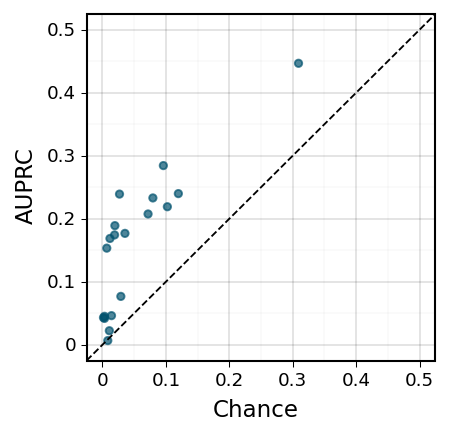

<ggplot: (2994082533405)>

In [4]:
ax = (
    ggplot(stats_df, aes(x='label', y='auprc'))
    + geom_point(color=COLORS['dark_blue'], alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + lims(x=[0, .5], y=[0, .5])
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)

ax.save('figures/Yeast_ChIPexo_auprc_v_chance.pdf')

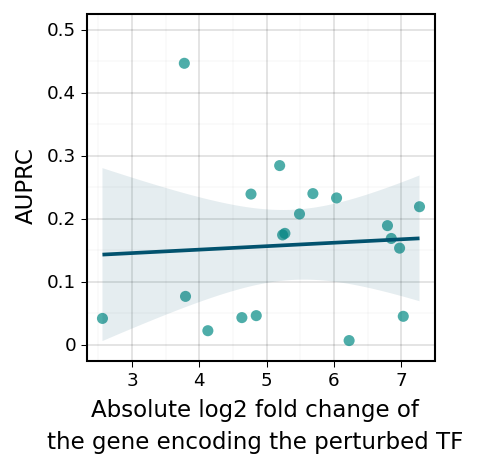

<ggplot: (2994083296453)>

In [5]:
pert_df = pd.read_csv('../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv', index_col=0)

pert_fc = pd.DataFrame()

for tf in sorted(stats_df['tf'].unique()):
    row = pd.Series({
        'tf': tf,
        'lfc': pert_df[tf].loc[tf]
    })
    pert_fc = pert_fc.append(row, ignore_index=True)
    
plot_df = stats_df.merge(pert_fc, how='left', on='tf')
plot_df['absLFC'] = np.abs(plot_df['lfc'])

ax = (
    ggplot(plot_df, aes(x='absLFC', y='auprc'))
    + geom_point(alpha=.7, size=3, stroke=0, color=COLORS['dark_green'])
    + geom_smooth(method='lm', color=COLORS['dark_blue'], fill=COLORS['dark_blue'], alpha=.1)
    + labs(x='Absolute log2 fold change of\nthe gene encoding the perturbed TF', y='AUPRC')
    + lims(y=[0, .5])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150,
        axis_title=element_text(lineheight=1.5))
)

display(ax)

ax.save('figures/Yeast_ChIPexo_auprc_v_tfpert_quality.pdf')

# Net influence calculated using SHAP values

- Distribution across TFs of the “net influence” of each feature on predictions, averaged over responsive targets. 
- Net influence is the sum of all SHAP values for a feature, regardless of sign or genomic position.
- TFs are filtered by the AUPRC significance against random model

In [8]:
perm_df = pd.read_csv('tables/SupplementalTable_ChIP-exo.csv')
perm_df['TF_sys'] = perm_df['TF'].apply(lambda x: x.split(' ')[0])
tfs = perm_df.loc[perm_df['For SHAP analysis'], 'TF_sys']

sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    sss_subdf = calculate_resp_and_unresp_signed_shap_sum(output_dir, organism=organism, tfs=tf_chunk)
    sss_df = sss_df.append(sss_subdf)

sss_df.to_csv(output_dir + 'signed_shap_sum.csv.gz')

sss_df = sss_df.merge(stats_df[['tf', 'auprc']], on='tf', how='left')
net_inf_df = calculate_shap_net_influence(sss_df)

Working on TF chunk 0, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...


All TFs (n=12)
Outliers


,feat_type_name,label_name,shap_diff,tf
124,TF binding,Responsive,0.812984,YJR060W


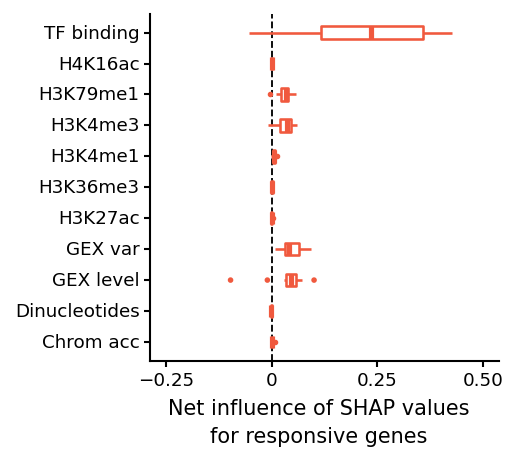

<ggplot: (-9223369042748745023)>

In [11]:
# Plot all models
plot_df = net_inf_df[(net_inf_df['label_name'] == 'Responsive')]
print('All TFs (n={})'.format(len(plot_df['tf'].unique())))

print('Outliers')
display(plot_df[plot_df['shap_diff'] > .5])

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + coord_flip()
    + ylim(-.25, .5)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(3, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)

display(ax)

ax.save('figures/Yeast_ChIPexo_net_influence.pdf')

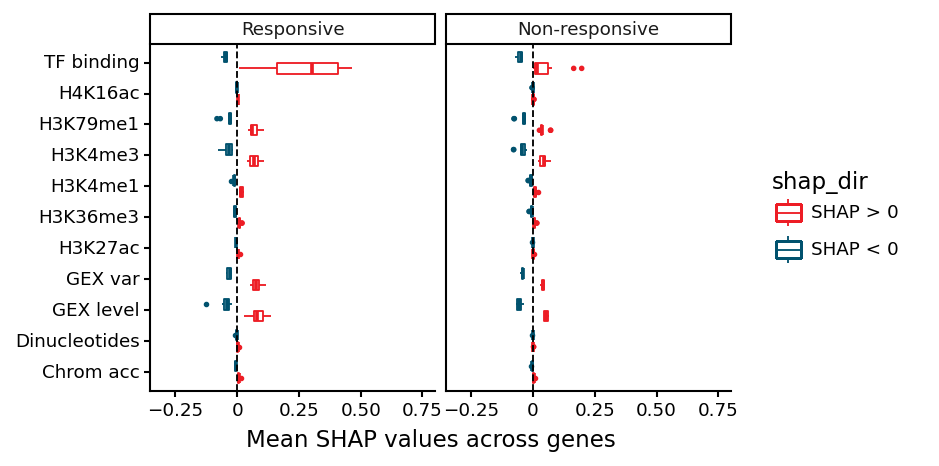

<ggplot: (-9223369042736819182)>

In [12]:
ax = (
    ggplot(sss_df, aes(x='feat_type_name', y='shap', color='shap_dir'))
    + geom_boxplot(alpha=.8, outlier_size=.5)
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + scale_color_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('label_name')
    + ylim(-.3, .75)
    + labs(x=None, y='Mean SHAP values across genes')
    + theme_classic()
    + theme(
        figure_size=(5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_ChIPexo_pos_neg_influence.pdf')